Available scalar tags:
  - Params/total_trainable
  - Gradients/grad_norm
  - Time/avg_batch_time
  - Loss/train
  - PSNR/val
  - Learning_Rate
  - Memory/gpu_mem

===== Scalar Summary =====
              metric           min           max          mean          last
 Avg. Batch Time (s)      0.601831      0.653724      0.603564      0.603675
     GPU Memory (MB)      6.345257      6.352015      6.351587      6.352015
       Gradient Norm   2048.000000 524288.000000 108888.915022 262144.000000
       Learning Rate      0.000063      0.000500      0.000279      0.000063
Trainable Parameters 863556.000000 863556.000000 863556.000000 863556.000000
       Training Loss      0.024741      0.160271      0.027361      0.024989
Validation PSNR (dB)     27.271124     29.329582     28.896848     29.303825


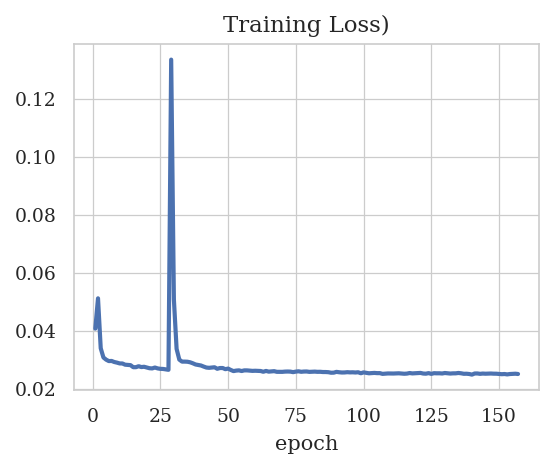

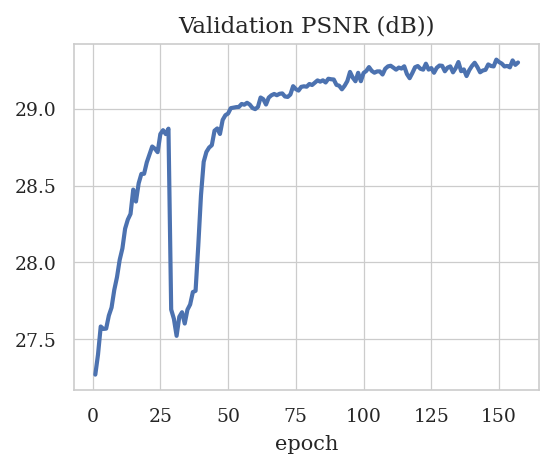

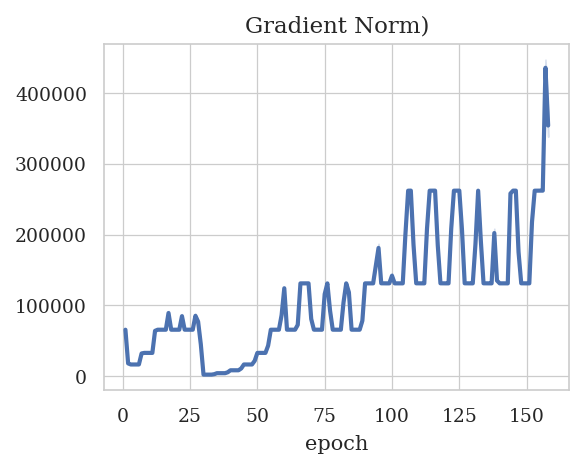

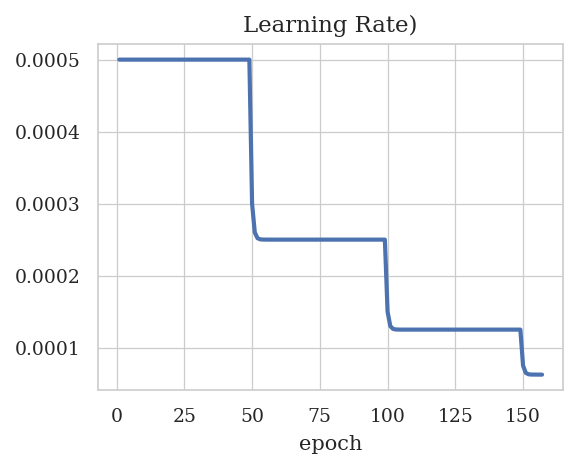

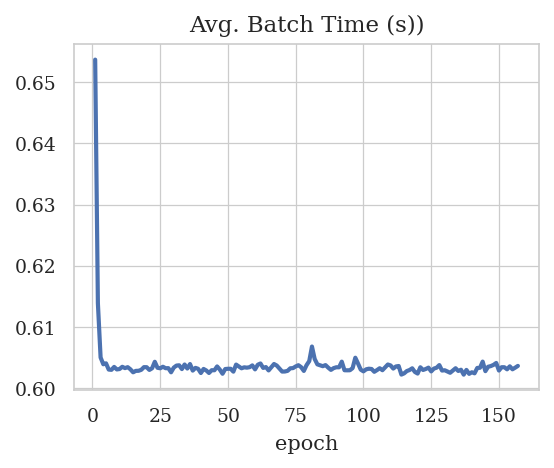

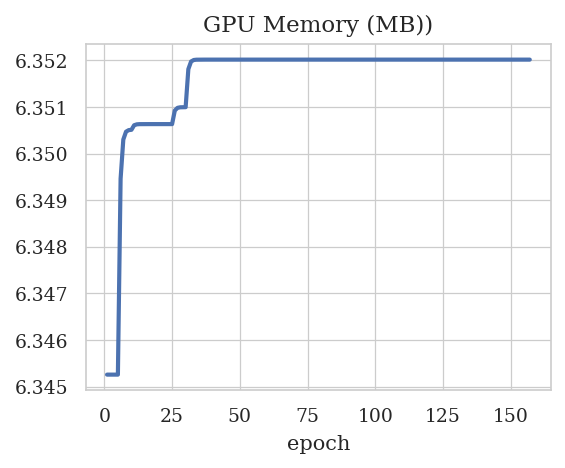

[INFO] Skipping plot for constant scalar: Trainable Parameters


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import numpy as np
from functools import partial

SMOOTHING_ALPHA = 1 - 0.2
logdir = "logs/logs_170epoch"

ea = event_accumulator.EventAccumulator(
    logdir,
    size_guidance={"scalars": 0}
)
ea.Reload()

print("Available scalar tags:")
for tag in ea.Tags()["scalars"]:
    print(f"  - {tag}")

SCALARS = {
    "Loss/train": "Training Loss",
    "PSNR/val": "Validation PSNR (dB)",
    "Gradients/grad_norm": "Gradient Norm",
    "Learning_Rate": "Learning Rate",
    "Time/avg_batch_time": "Avg. Batch Time (s)",
    "Memory/gpu_mem": "GPU Memory (MB)",
    "Params/total_trainable": "Trainable Parameters",
}

records = []

for tag, label in SCALARS.items():
    for e in ea.Scalars(tag):
        records.append({
            "metric": label,
            "step": e.step,
            "value": e.value,
        })

df = pd.DataFrame(records)

summary = (
    df.groupby("metric")["value"]
    .agg(["min", "max", "mean", "last"])
    .reset_index()
)

print("\n===== Scalar Summary =====")
print(summary.to_string(index=False))

df = df.sort_values("step")

df["value_smooth"] = (
    df.groupby("metric")["value"]
      .apply(lambda x: x.ewm(alpha=SMOOTHING_ALPHA, adjust=False).mean())
      .reset_index(level=0, drop=True)
)

sns.set_theme(
    context="paper",
    style="whitegrid",
    font="serif",
    rc={
        "figure.dpi": 150,
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.6,
        "axes.labelsize": 10,
        "axes.titlesize": 11,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
    }
)

for metric in SCALARS.values():

    df_metric = df[df["metric"] == metric]

    if df_metric["value"].nunique() == 1:
        print(f"[INFO] Skipping plot for constant scalar: {metric}")
        continue
    #if metric != "Training Loss":
     # continue

    plt.figure(figsize=(4, 3))

    sns.lineplot(
        data=df_metric,
        x="step",
        y="value_smooth",
        linewidth=2
    )
    plt.title(f"{metric})")
    plt.xlabel("Training Step")
    plt.ylabel("")
    plt.xlabel("epoch")
    plt.grid(True)

    fname = metric.lower().replace(" ", "_").replace("(", "").replace(")", "")
    # plt.savefig(f"{fname}.pdf", bbox_inches="tight")
    # plt.savefig(f"{fname}.svg", bbox_inches="tight")

    plt.show()


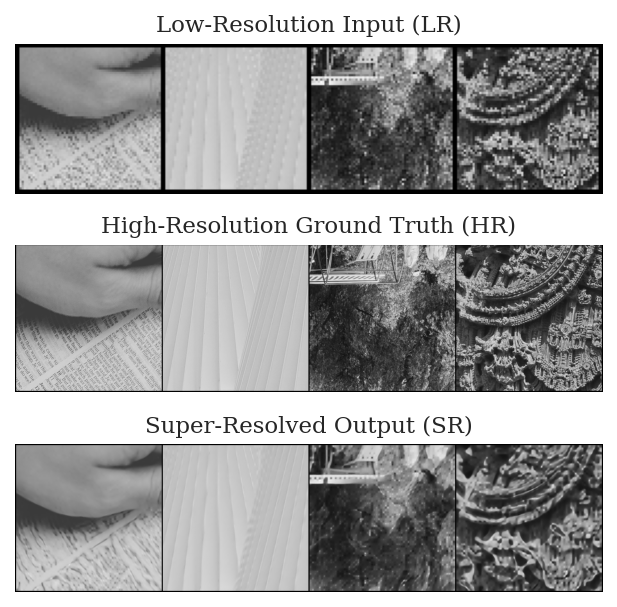

In [3]:
import io
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

def load_event_accumulator(logdir):
    ea = event_accumulator.EventAccumulator(
        logdir,
        size_guidance={"images": 0}
    )
    ea.Reload()
    return ea


def get_image_event(ea, tag, step="last"):
    events = ea.Images(tag)
    if step == "last":
        return events[-1]
    for e in events:
        if e.step == step:
            return e
    raise ValueError(f"Step {step} not found for tag '{tag}'")


def decode_image(event):
    return Image.open(io.BytesIO(event.encoded_image_string)).convert("RGB")


def compute_diff_image(sr_img, hr_img, scale=100):
    sr = np.asarray(sr_img).astype(np.float32) / 255.0
    hr = np.asarray(hr_img).astype(np.float32) / 255.0
    diff = np.abs(sr - hr) * scale
    diff = np.clip(diff, 0, 1)
    return Image.fromarray((diff * 255).astype(np.uint8))



def show_sr_comparison(
    logdir,
    step="last",
    save_path=None
):
    ea = load_event_accumulator(logdir)

    tags = {
        "LR": "Images/LR",
        "HR": "Images/HR",
        "SR": "Images/SR",
    }

    # --- Load images ---
    images = {}
    for name, tag in tags.items():
        event = get_image_event(ea, tag, step)
        images[name] = decode_image(event)
        epoch = event.step

    # --- Compute difference ---
    scale =1000
    diff_img = compute_diff_image(images["SR"], images["HR"], scale=scale)
    fig, axes = plt.subplots(
        nrows=3,
        ncols=1,
        figsize=(4, 4),
        constrained_layout=True
    )

    row_titles = [
        "Low-Resolution Input (LR)",
        "High-Resolution Ground Truth (HR)",
        "Super-Resolved Output (SR)"
    ]

    plot_images = [
        images["LR"],
        images["HR"],
        images["SR"]

    ]

    for ax, img, title in zip(axes, plot_images, row_titles):
        ax.imshow(img)
        ax.set_title(title, fontsize=11)
        ax.axis("off")

    if save_path:
        fig.savefig(save_path, bbox_inches="tight")
        print(f"[Saved figure] {save_path}")

    plt.show()


show_sr_comparison(logdir="logs/logs_170epoch", step="last")


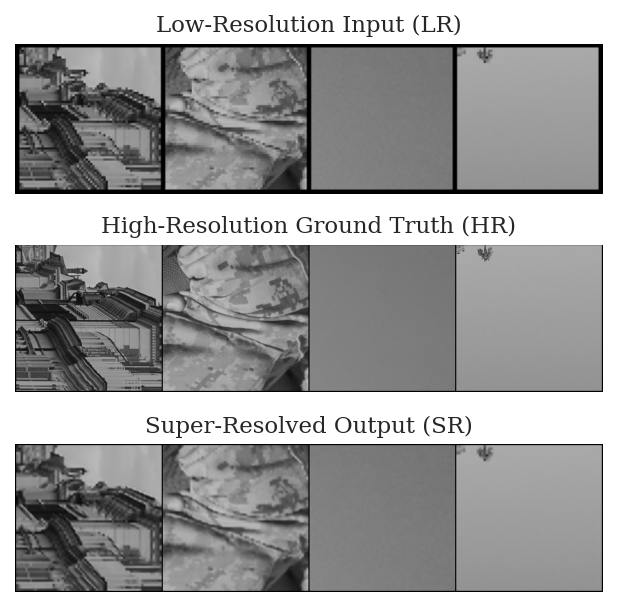

In [4]:
show_sr_comparison(logdir="logs/logs_170epoch", step=10)

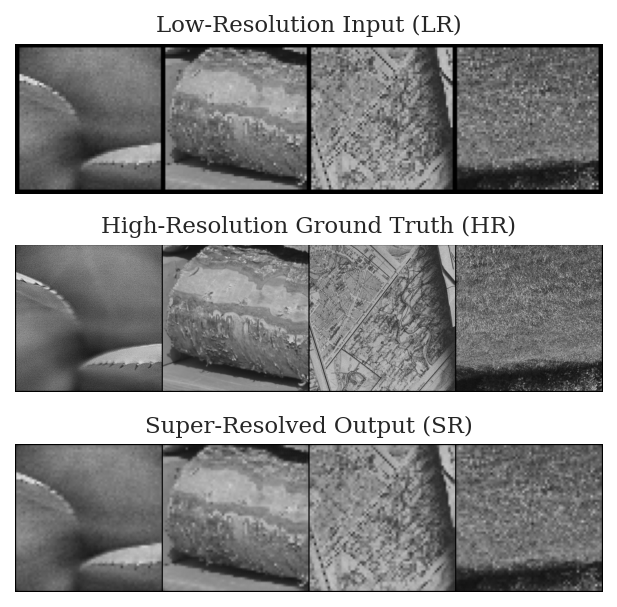

In [5]:
show_sr_comparison(logdir="logs/logs_170epoch", step=30)

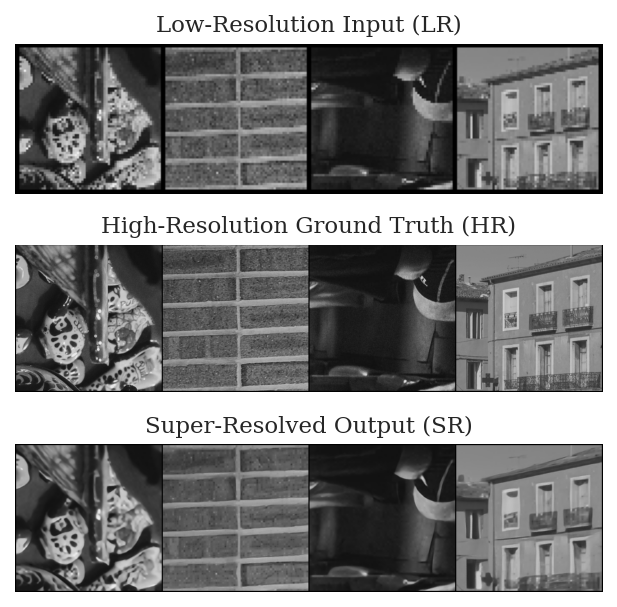

In [6]:
show_sr_comparison(logdir="logs/logs_170epoch", step=150)

SSIM metric

In [8]:
import torch
import torch.nn.functional as F
import math


def calc_ssim(sr, hr, scale, data_range=1.0, window_size=11, sigma=1.5):

    if scale > 0:
        sr = sr[:, :, scale:-scale, scale:-scale]
        hr = hr[:, :, scale:-scale, scale:-scale]

    device = sr.device
    channel = sr.size(1)

    coords = torch.arange(window_size, device=device) - window_size // 2
    g = torch.exp(-(coords ** 2) / (2 * sigma ** 2))
    g = g / g.sum()
    window_1d = g.unsqueeze(0)
    window_2d = window_1d.T @ window_1d
    window = window_2d.expand(channel, 1, window_size, window_size)

    mu_sr = F.conv2d(sr, window, padding=window_size // 2, groups=channel)
    mu_hr = F.conv2d(hr, window, padding=window_size // 2, groups=channel)

    mu_sr_sq = mu_sr ** 2
    mu_hr_sq = mu_hr ** 2
    mu_sr_hr = mu_sr * mu_hr
    sigma_sr_sq = F.conv2d(sr * sr, window, padding=window_size // 2, groups=channel) - mu_sr_sq
    sigma_hr_sq = F.conv2d(hr * hr, window, padding=window_size // 2, groups=channel) - mu_hr_sq
    sigma_sr_hr = F.conv2d(sr * hr, window, padding=window_size // 2, groups=channel) - mu_sr_hr

    C1 = (0.01 * data_range) ** 2
    C2 = (0.03 * data_range) ** 2
    ssim_map = ((2 * mu_sr_hr + C1) * (2 * sigma_sr_hr + C2)) / \
               ((mu_sr_sq + mu_hr_sq + C1) * (sigma_sr_sq + sigma_hr_sq + C2))

    return ssim_map.mean().item()


x = torch.rand(1, 1, 256, 256)
ssim = calc_ssim(sr=x, hr=x, scale=4)
print(ssim)  # normalement 1


1.0


des tests sur la SSIM

In [9]:
hr = torch.rand(1, 1, 128, 128)
noise = 0.01 * torch.randn_like(hr)
sr = torch.clamp(hr + noise, 0, 1)

ssim = calc_ssim(sr=sr, hr=hr, scale=4)
print("SSIM (small noise):", ssim)

SSIM (small noise): 0.9994031190872192


In [10]:
x = torch.arange(128)
y = torch.arange(128)
xx, yy = torch.meshgrid(x, y, indexing="ij")
hr = ((xx // 8 + yy // 8) % 2).float()
hr = hr.unsqueeze(0).unsqueeze(0)

from torchvision.transforms import GaussianBlur
blur = GaussianBlur(kernel_size=9, sigma=2.0)
sr = blur(hr)

ssim = calc_ssim(sr=sr, hr=hr, scale=4)
print("SSIM (blurred structured image):", ssim)


SSIM (blurred structured image): 0.48638030886650085


In [11]:
hr = torch.zeros(1, 1, 128, 128)
sr = torch.rand(1, 1, 128, 128)

ssim = calc_ssim(sr=sr, hr=hr, scale=4)
print("SSIM (unrelated images):", ssim)


SSIM (unrelated images): 4.966246251569828e-06
